### Install Packages

First, we have to load packages used in R.

In [1]:
library(plyr)
library(car)
library(broom)
library(ggplot2)
library(gridExtra)

Loading required package: carData


Suppress warnings globally in an R Script!

In [2]:
#options( warn = -1 )

We then read the given dataset into R and check if the dataset have missing data or NA.

In [3]:
AHPR <- read.csv("datasets/AHPR.csv")
NAs <- function(x) { as.vector(apply(x, 2, function(x) length(which(is.na(x)))))}
cat(NAs(AHPR))

0 0 0 0 0 0 0 0

### TASK 1: THE MINIMUM BIAS APPROACH
#### * Use a GLM to obtain the same relatives as the minimum bias method, and display the relativities.

In this assignment, we are going to take the given dataset and write up a report to conduct some business activities using statistical models of general insurance data.

To check the GLM model with Poisson distribution and Logarithmic link function corresponds to the minimum bias producedure with multiplicative balance principle, we start with the quasi-Poisson model. (The reason we are not using Poisson model is because the response variable, PP, does not follow exponentials in the real word.)

In [4]:
glm1 <- glm(PP ~ factor(Kilometres) + factor(Zone), 
            data=AHPR, family=quasipoisson(link="log"), weights=Insured)

summary(glm1)


Call:
glm(formula = PP ~ factor(Kilometres) + factor(Zone), family = quasipoisson(link = "log"), 
    data = AHPR, weights = Insured)

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-1382.87    -84.45    -23.22     98.25   2289.46  

Coefficients:
                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)          5.61346    0.03368 166.680  < 2e-16 ***
factor(Kilometres)2  0.20921    0.03066   6.824 1.15e-11 ***
factor(Kilometres)3  0.24873    0.03471   7.166 1.06e-12 ***
factor(Kilometres)4  0.33511    0.04767   7.029 2.77e-12 ***
factor(Kilometres)5  0.52333    0.05085  10.291  < 2e-16 ***
factor(Zone)2       -0.23480    0.03986  -5.890 4.46e-09 ***
factor(Zone)3       -0.37368    0.04027  -9.278  < 2e-16 ***
factor(Zone)4       -0.50205    0.03549 -14.145  < 2e-16 ***
factor(Zone)5       -0.29748    0.06000  -4.958 7.68e-07 ***
factor(Zone)6       -0.41253    0.04756  -8.674  < 2e-16 ***
factor(Zone)7       -0.75113    0.17005  -4.417 1.05e-0

Since the base class in the minimum bias producedure is Kilometres=1 and Zone=1, the pure premium for the base class is:

In [5]:
fitted_avg_PP <- exp(glm1$coeff[1])
cat(fitted_avg_PP)

274.0901

The overall average pure premium, which equal total amount of payment divided by total amount of insured, can be computed as follows:

In [6]:
observed_avg_PP <- sum(AHPR$Payment)/sum(AHPR$Insured)
cat(observed_avg_PP)

235.3129

The relatives for variables Kilometres and Zone are then:

In [7]:
relatives <- exp(glm1$coeff ) * sqrt(fitted_avg_PP / observed_avg_PP)
relatives[1] <- sqrt(fitted_avg_PP / observed_avg_PP)

names(relatives) <- c("Base","Kilometres 2","Kilometres 3", "Kilometres 4", "Kilometres 5", 
                      "Zone 2", "Zone 3","Zone 4", "Zone 5", "Zone 6", "Zone 7")

In [8]:
relatives[1:5]

Base Kilometres 2 Kilometres 3 Kilometres 4 Kilometres 5 
    1.079254     1.330406     1.384038     1.508904     1.821399

In [9]:
relatives[c(1,6:11)]

Base    Zone 2    Zone 3    Zone 4    Zone 5    Zone 6    Zone 7 
1.0792544 0.8533947 0.7427407 0.6532613 0.8015465 0.7144357 0.5092293

#### * Verify that your results are in balance (using exposures as weights) only for Zone 1.

Since the only variables currently being used are Kilometres and Zone in the minimum bias procedure, we have to sort the dataset by these two variables and then we have to compute the pure premium corresponding to each group.

In [10]:
AHPR1 <- AHPR

groupColumns = c("Kilometres","Zone"); dataColumns = c("Insured","Payment")
AHPR_sorted <- ddply(AHPR1, groupColumns, function(x) colSums(x[dataColumns]))

observed_PP = AHPR_sorted$Payment/AHPR_sorted$Insured
AHPR_observed <- cbind(AHPR_sorted, observed_PP)

head(AHPR_observed,5)

Kilometres,Zone,Insured,Payment,observed_PP
1,1,113842.13,30902212,271.4479
1,2,130747.13,28896696,221.0121
1,3,149560.59,28346933,189.5348
1,4,279934.65,44563016,159.1908
1,5,43765.69,9197220,210.1468


To verify our results are in balance for Zone 1, we need to subset our dataset, inclding fitted pure premium, by Zone = 1.

In [11]:
glm2 <- glm(observed_PP ~ factor(Kilometres) + factor(Zone), 
            data=AHPR_observed, family=quasipoisson(link="log"), weights=Insured)

AHPR_fitted <- cbind(AHPR_observed, fitted_PP = glm2$fitted)
AHPR_fitted_Zone1 <- subset(AHPR_fitted, AHPR_fitted$Zone == 1)

head(AHPR_fitted_Zone1)

,Kilometres,Zone,Insured,Payment,observed_PP,fitted_PP
1,1,1,113842.13,30902212,271.4479,274.0901
8,2,1,112304.44,38692904,344.5358,337.8733
15,3,1,65150.23,22244956,341.4409,351.4936
22,4,1,20777.63,7409238,356.5969,383.2051
29,5,1,14319.67,7384158,515.6654,462.5669


Multiply insured by observed pure premiums for Zone 1, we obtain the following value:

In [12]:
cat(sum(AHPR_fitted_Zone1$Insured * AHPR_fitted_Zone1$observed_PP))

106633468

Multiply insured by fitted pure premiums for Zone 1, we obtain the following value:

In [13]:
cat(sum(AHPR_fitted_Zone1$Insured * AHPR_fitted_Zone1$fitted_PP))

106633468

Since both values are the same, 106633468, we conclude our results are in balance for Zone 1.

### TASK 2: SELECTING A GLM
#### * Preparing the Data

For this task, we first create a new dataset which has the same data as the original one.

In [14]:
AHPR2 <- AHPR

One of the classes of each variable, Kilometres or Zone, should be assigned as the base class by counting the number of exposures corresponding to each level of the corresponding variable.

In [15]:
groupColumns = c("Kilometres");  dataColumns = c("Insured")
levels_Kilometres <- ddply(AHPR2,groupColumns,function(x) colSums(x[dataColumns]))
levels_Kilometres 

Kilometres,Insured
1,806801.3
2,804396.7
3,477149.4
4,173150.0
5,121672.6


In [16]:
groupColumns = c("Zone"); dataColumns = c("Insured")
levels_Zone <- ddply(AHPR2, groupColumns, function(x) colSums(x[dataColumns]))
levels_Zone  

Zone,Insured
1,326394.10
2,387916.78
3,429331.99
4,847154.83
5,120442.99
6,252845.64
7,19083.75


After finding the base class for each variable, we can reset the base class of each variable. The base class for variable Kilometres is 1, and the base class for variable Zone is 4.

In [17]:
AHPR2$Zone <- as.factor(AHPR2$Zone)
AHPR2$Zone <- relevel(AHPR2$Zone,c("4"))

To check the final dataset to be the one we intended to work on, run a linear regression analysis of PP on variables Kilometres and Zone.

In [18]:
AHPRrep <- lm(PP~factor(Kilometres)+factor(Zone),weights=Insured,data=AHPR2)
summary(AHPRrep)$coef

,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),159.72462,6.467027,24.698307,6.687648e-119
factor(Kilometres)2,45.82133,7.167575,6.392863,1.986925e-10
factor(Kilometres)3,55.53831,8.309325,6.683854,2.949246e-11
factor(Kilometres)4,77.80709,12.051988,6.455955,1.322616e-10
factor(Kilometres)5,133.99112,13.992906,9.575646,2.649770e-21
factor(Zone)1,129.29360,9.374217,13.792469,1.515014e-41
factor(Zone)2,61.06931,8.819307,6.924502,5.741203e-12
factor(Zone)3,27.40580,8.523011,3.215507,1.321272e-03
factor(Zone)5,45.19479,14.011777,3.225486,1.276278e-03
factor(Zone)6,18.67742,10.308266,1.811888,7.014167e-02


#### * Residual plot, Normal Q-Q plot and Histogram

To produce the residual plot, Normal Q-Q plot and histogram of deviance residuals of our quasi-Poisson model, we first define one function called my.glm.function for plotting purposes.

In [19]:
my.glm.function <- function(my.glm.model)
{
  dev <- residuals(my.glm.model, type = c("deviance"))
  df <- augment(my.glm.model)
  plot1 <- ggplot(df, aes(x = .fitted, y = .resid)) + 
           geom_point() +
           ggtitle("Plot of Deviance Residuals \n vs. Predicted Values") +
           xlab("Predicted Value") + ylab("Deviance Residual") +
           geom_smooth(method = "lm", se=FALSE, color="red", formula = y ~ x) +
           theme(plot.title = element_text(size = 8),aspect.ratio=1,
             axis.title.x=element_text(size=8),axis.text.x=element_text(size=7),
             axis.title.y=element_text(size=8),axis.text.y=element_text(size=7))
  plot2 <- ggplot(data=as.data.frame(qqnorm(dev,plot=F)),mapping=aes(x=x,y=y)) +
           geom_point() +
           ggtitle("Normal Q-Q Plot \n") +
           xlab("Theoretical Quantiles") + ylab("Sample Quantiles") +
           geom_smooth(method = "lm", se=FALSE, color="red", formula = y ~ x) +
           theme(plot.title = element_text(size = 8),aspect.ratio=1,
             axis.title.x=element_text(size=8),axis.text.x=element_text(size=7),
             axis.title.y=element_text(size=8),axis.text.y=element_text(size=7))
  plot3 <- ggplot(df, aes(x=dev)) + 
           geom_histogram(color="black", fill="black", binwidth = 15) +
           geom_vline(aes(xintercept=mean(dev, na.rm=T)), color="red", size=1) +
           ggtitle("Histogram of \n Deviance Residuals") + xlab("Deviance Residuals") +
           theme(plot.title = element_text(size = 8),aspect.ratio=1,
             axis.title.x=element_text(size=8),axis.text.x=element_text(size=7),
             axis.title.y=element_text(size=8),axis.text.y=element_text(size=7))
  grid.arrange(plot1, plot2, plot3, nrow=1, ncol=3)
} 

#### * The Poisson-multiplicative Model

We begin our GLM with Poisson distribution and Logarithmic link function.

Usually we can use the Akaike information criterion (AIC) to assess model selection which penalized for adding more parameters. However, as we can see below, AIC doesn't work in our Poisson model. This is probabily because the variable, pure premium, takes on non-integer values.

Since the Poisson-multiplicative Model will produce the following messy messages:
    
    Warning message in dpois(y, mu, log = TRUE):
        "non-integer x = 862.371191"Warning message in dpois(y, mu, log = TRUE):
        ....

If we want temporary turn off these warnings, the safest way is using:

    oldw <- getOption("warn")
    options(warn = -1)
    [your "silenced" code]
    options(warn = oldw)

In [20]:
oldw <- getOption("warn")
options(warn = -1)

In [21]:
poiss <- glm(PP ~ factor(Kilometres) + factor(Zone), data=AHPR2, family=poisson(link="log"), weights=Insured)

summary(poiss)


Call:
glm(formula = PP ~ factor(Kilometres) + factor(Zone), family = poisson(link = "log"), 
    data = AHPR2, weights = Insured)

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-1382.87    -84.45    -23.22     98.25   2289.46  

Coefficients:
                      Estimate Std. Error z value Pr(>|z|)    
(Intercept)          5.1114086  0.0001027 49792.5   <2e-16 ***
factor(Kilometres)2  0.2092139  0.0001069  1957.8   <2e-16 ***
factor(Kilometres)3  0.2487346  0.0001210  2055.9   <2e-16 ***
factor(Kilometres)4  0.3351133  0.0001662  2016.8   <2e-16 ***
factor(Kilometres)5  0.5233342  0.0001772  2952.6   <2e-16 ***
factor(Zone)1        0.5020485  0.0001237  4058.4   <2e-16 ***
factor(Zone)2        0.2672450  0.0001258  2123.5   <2e-16 ***
factor(Zone)3        0.1283698  0.0001274  1007.4   <2e-16 ***
factor(Zone)5        0.2045657  0.0002007  1019.2   <2e-16 ***
factor(Zone)6        0.0895158  0.0001549   577.9   <2e-16 ***
factor(Zone)7       -0.2490788  0.000

In [22]:
options(warn = oldw)

If we change to use the quasi-Poisson model, AIC problem may also exist. Notice that the dispersion parameter for poisson family taken to be 1 but for quasi-poisson family taken to be greater than 1, even though both models have the same coefficients of estimate and deviances. This kind of overdispersion is due to the Poisson model has only one parameter and the variance equals the mean. The quasi-Poisson model, however, assume the variance is a linear function of the mean:

In [23]:
qpoiss_mult <- glm(PP ~ factor(Kilometres) + factor(Zone), 
                   data=AHPR2, family=quasipoisson(link="log"), weights=Insured)

summary(qpoiss_mult)


Call:
glm(formula = PP ~ factor(Kilometres) + factor(Zone), family = quasipoisson(link = "log"), 
    data = AHPR2, weights = Insured)

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-1382.87    -84.45    -23.22     98.25   2289.46  

Coefficients:
                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)          5.11141    0.02945 173.548  < 2e-16 ***
factor(Kilometres)2  0.20921    0.03066   6.824 1.15e-11 ***
factor(Kilometres)3  0.24873    0.03471   7.166 1.06e-12 ***
factor(Kilometres)4  0.33511    0.04767   7.029 2.77e-12 ***
factor(Kilometres)5  0.52333    0.05085  10.291  < 2e-16 ***
factor(Zone)1        0.50205    0.03549  14.145  < 2e-16 ***
factor(Zone)2        0.26724    0.03611   7.401 1.92e-13 ***
factor(Zone)3        0.12837    0.03656   3.511 0.000455 ***
factor(Zone)5        0.20457    0.05759   3.552 0.000390 ***
factor(Zone)6        0.08952    0.04445   2.014 0.044126 *  
factor(Zone)7       -0.24908    0.16921  -1.472 0.1411

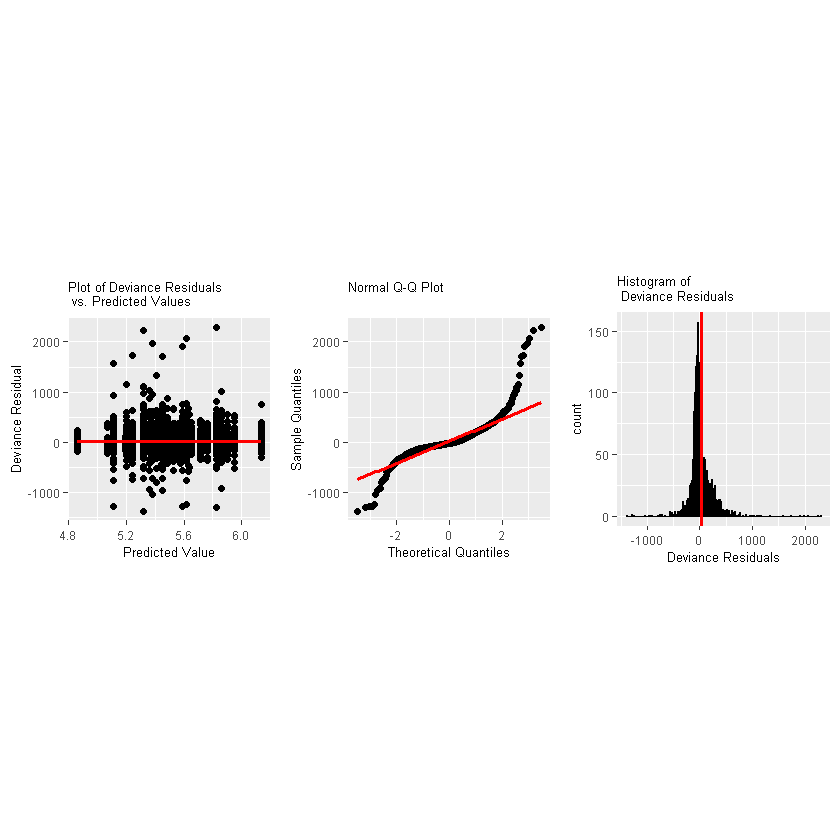

In [24]:
my.glm.function(qpoiss_mult)

#### * The Poisson-additive Model

Add start values of coefficients to avoid the problem that the predicted mean might be negative.

In [25]:
qpoiss_add <- glm(PP ~ factor(Kilometres) + factor(Zone), 
                  data=AHPR2, family=quasipoisson(link="identity"), weights=Insured, 
                  start=c(5.11,0.20,0.24,0.33,0.52,0.50,0.26,0.12,0.20,0.08,-0.24))

summary(qpoiss_add)


Call:
glm(formula = PP ~ factor(Kilometres) + factor(Zone), family = quasipoisson(link = "identity"), 
    data = AHPR2, weights = Insured, start = c(5.11, 0.2, 0.24, 
        0.33, 0.52, 0.5, 0.26, 0.12, 0.2, 0.08, -0.24))

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-1414.00    -83.74    -23.47     96.94   2318.55  

Coefficients:
                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)          160.492      5.525  29.047  < 2e-16 ***
factor(Kilometres)2   44.517      6.599   6.746 1.94e-11 ***
factor(Kilometres)3   54.807      7.860   6.973 4.11e-12 ***
factor(Kilometres)4   77.398     12.091   6.401 1.88e-10 ***
factor(Kilometres)5  129.896     15.361   8.456  < 2e-16 ***
factor(Zone)1        127.614     10.009  12.750  < 2e-16 ***
factor(Zone)2         60.986      8.556   7.128 1.39e-12 ***
factor(Zone)3         27.768      7.835   3.544 0.000402 ***
factor(Zone)5         45.526     13.480   3.377 0.000745 ***
factor(Zone)6         20.7

Three graphs of our Poisson-additive model are:

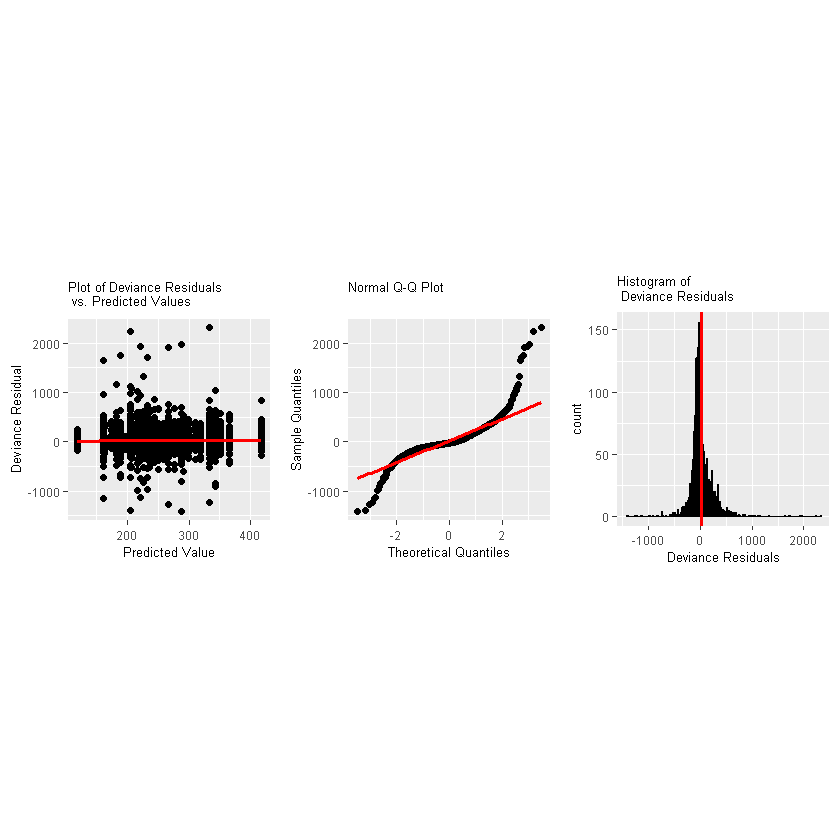

In [26]:
my.glm.function(qpoiss_add)

#### * The Gamma-multiplicative Model

We begin the Gamma model analysis by cleanning and modifying our general insurance data, since non-positive values are not allowed for the gamma family and we have some zero's in the dataset.

In [27]:
PP_pos <- AHPR2[,8] 
# Replacing 0 by 0.001 in PP_pos 
PP_pos[AHPR2[,7]==0] <- 0.001 
# Adding the PP_pos column to the dataset AHPR2
AHPR2$PP_pos <- PP_pos 

gamma_mult <- glm(PP_pos ~ factor(Kilometres) + factor(Zone), 
                  data=AHPR2, family=Gamma(link="log"), weights=Insured, 
                  start=c(5.11,0.20,0.24,0.33,0.52,0.50,0.26,0.12,0.20,0.08,-0.24)) 

summary(gamma_mult)


Call:
glm(formula = PP_pos ~ factor(Kilometres) + factor(Zone), family = Gamma(link = "log"), 
    data = AHPR2, weights = Insured, start = c(5.11, 0.2, 0.24, 
        0.33, 0.52, 0.5, 0.26, 0.12, 0.2, 0.08, -0.24))

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-103.643    -8.855    -2.171     5.782   134.081  

Coefficients:
                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)          5.10637    0.02653 192.483  < 2e-16 ***
factor(Kilometres)2  0.20996    0.02940   7.141 1.26e-12 ***
factor(Kilometres)3  0.25317    0.03409   7.427 1.58e-13 ***
factor(Kilometres)4  0.34303    0.04944   6.938 5.22e-12 ***
factor(Kilometres)5  0.51988    0.05740   9.057  < 2e-16 ***
factor(Zone)1        0.50399    0.03845  13.106  < 2e-16 ***
factor(Zone)2        0.27248    0.03618   7.532 7.31e-14 ***
factor(Zone)3        0.13302    0.03496   3.805 0.000146 ***
factor(Zone)5        0.21073    0.05748   3.666 0.000252 ***
factor(Zone)6        0.10055    0.

Three graphs of our Gamma-multiplicative model are:

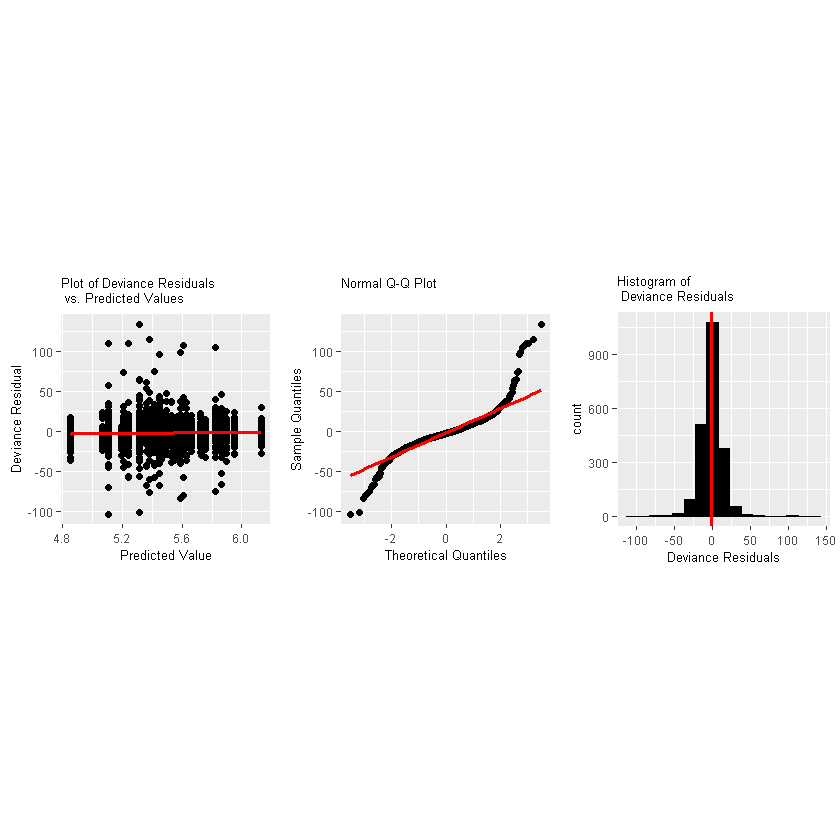

In [28]:
my.glm.function(gamma_mult)

#### * The Gamma-additive Model

In [29]:
gamma_add <- glm(PP_pos ~ factor(Kilometres) + factor(Zone), 
                 data=AHPR2, family=Gamma(link="identity"), weights=Insured, 
                 start=c(5.11,0.20,0.24,0.33,0.52,0.50,0.26,0.12,0.20,0.08,-0.24))

summary(gamma_add)


Call:
glm(formula = PP_pos ~ factor(Kilometres) + factor(Zone), family = Gamma(link = "identity"), 
    data = AHPR2, weights = Insured, start = c(5.11, 0.2, 0.24, 
        0.33, 0.52, 0.5, 0.26, 0.12, 0.2, 0.08, -0.24))

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-101.710    -8.850    -2.150     5.632   133.409  

Coefficients:
                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)          160.738      4.793  33.539  < 2e-16 ***
factor(Kilometres)2   43.730      6.202   7.051 2.38e-12 ***
factor(Kilometres)3   54.424      7.618   7.144 1.23e-12 ***
factor(Kilometres)4   77.326     12.468   6.202 6.66e-10 ***
factor(Kilometres)5  126.909     17.285   7.342 2.95e-13 ***
factor(Zone)1        126.257     11.107  11.367  < 2e-16 ***
factor(Zone)2         61.033      8.528   7.157 1.13e-12 ***
factor(Zone)3         28.127      7.351   3.826 0.000134 ***
factor(Zone)5         45.941     13.271   3.462 0.000547 ***
factor(Zone)6         22.655 

Three graphs of our Gamma-additive model are:

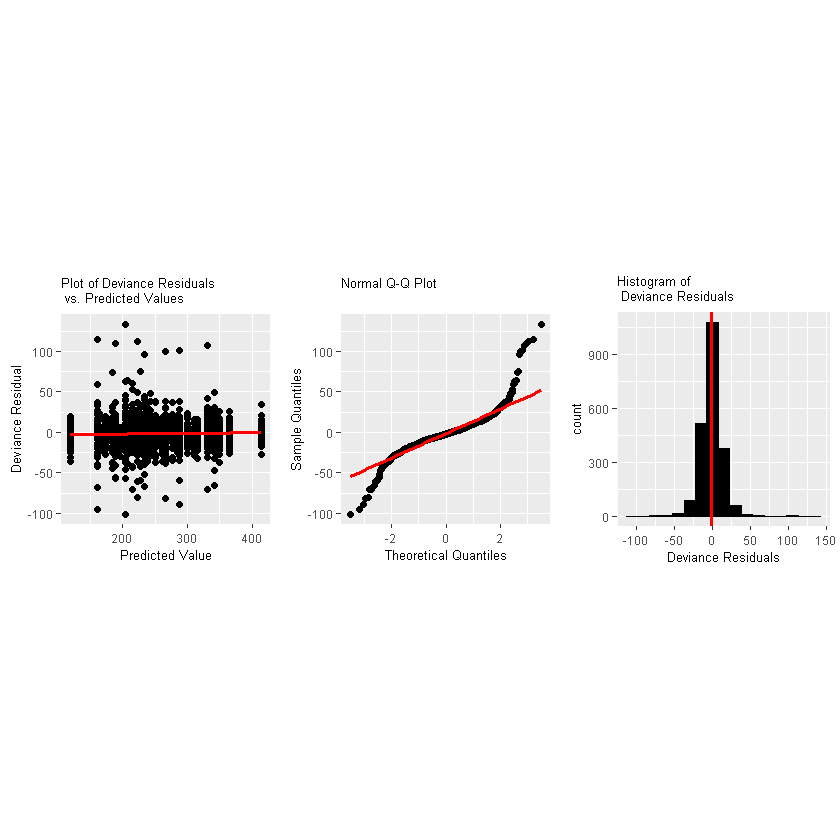

In [30]:
my.glm.function(gamma_add)

#### * The Gaussian-multiplicative Model

In [31]:
gauss_mult <- glm(PP_pos ~ factor(Kilometres) + factor(Zone), 
                  data=AHPR2, family=gaussian(link="log"), weights=Insured)

summary(gauss_mult)


Call:
glm(formula = PP_pos ~ factor(Kilometres) + factor(Zone), family = gaussian(link = "log"), 
    data = AHPR2, weights = Insured)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-22654   -1118    -277    1704   51601  

Coefficients:
                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)          5.11524    0.03310 154.528  < 2e-16 ***
factor(Kilometres)2  0.20974    0.03252   6.449 1.39e-10 ***
factor(Kilometres)3  0.24473    0.03611   6.777 1.57e-11 ***
factor(Kilometres)4  0.32730    0.04724   6.929 5.57e-12 ***
factor(Kilometres)5  0.53016    0.04636  11.435  < 2e-16 ***
factor(Zone)1        0.50139    0.03427  14.633  < 2e-16 ***
factor(Zone)2        0.26259    0.03701   7.095 1.75e-12 ***
factor(Zone)3        0.12375    0.03902   3.172 0.001538 ** 
factor(Zone)5        0.19872    0.05906   3.365 0.000779 ***
factor(Zone)6        0.07905    0.04787   1.651 0.098821 .  
factor(Zone)7       -0.24298    0.21194  -1.146 0.251733    
---
Signif. c

Three graphs of our Gaussian-multiplicative model are:

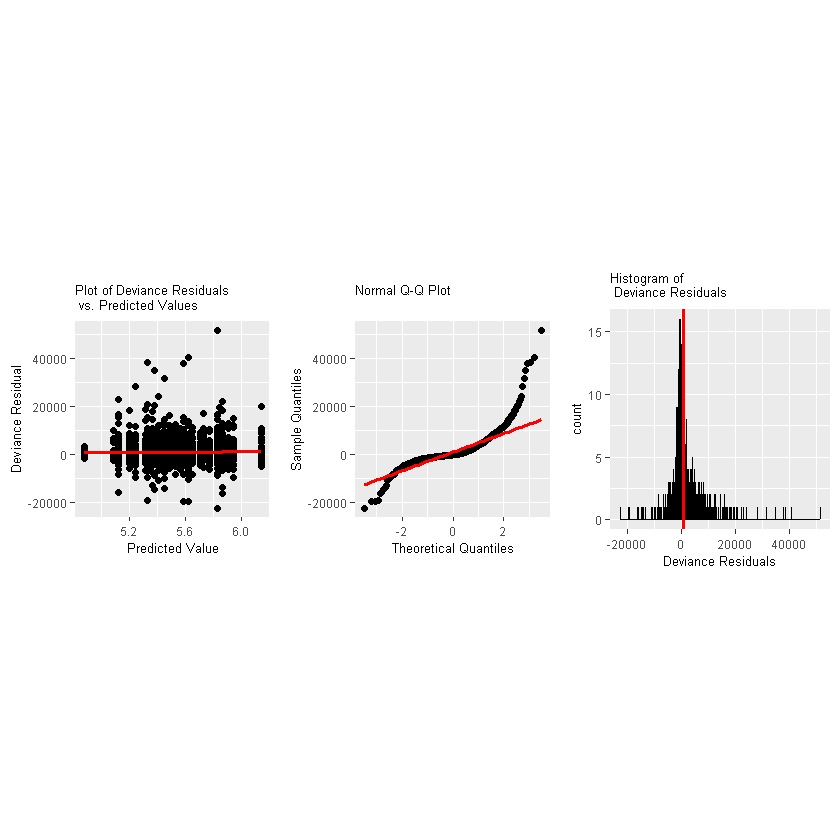

In [32]:
my.glm.function(gauss_mult)

#### * The Gaussian-additive Model

In [33]:
gauss_add <- glm(PP_pos ~ factor(Kilometres) + factor(Zone), 
                 data=AHPR2, family=gaussian(link="identity"), weights=Insured)

summary(gauss_add)


Call:
glm(formula = PP_pos ~ factor(Kilometres) + factor(Zone), family = gaussian(link = "identity"), 
    data = AHPR2, weights = Insured)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-22631   -1119    -278    1705   51954  

Coefficients:
                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)          159.725      6.467  24.698  < 2e-16 ***
factor(Kilometres)2   45.821      7.168   6.393 1.99e-10 ***
factor(Kilometres)3   55.538      8.309   6.684 2.95e-11 ***
factor(Kilometres)4   77.807     12.052   6.456 1.32e-10 ***
factor(Kilometres)5  133.991     13.993   9.576  < 2e-16 ***
factor(Zone)1        129.294      9.374  13.792  < 2e-16 ***
factor(Zone)2         61.069      8.819   6.925 5.74e-12 ***
factor(Zone)3         27.406      8.523   3.216  0.00132 ** 
factor(Zone)5         45.195     14.012   3.225  0.00128 ** 
factor(Zone)6         18.677     10.308   1.812  0.07014 .  
factor(Zone)7        -42.798     33.298  -1.285  0.19882    
---
Sign

Three graphs of our Gaussian-additive model are:

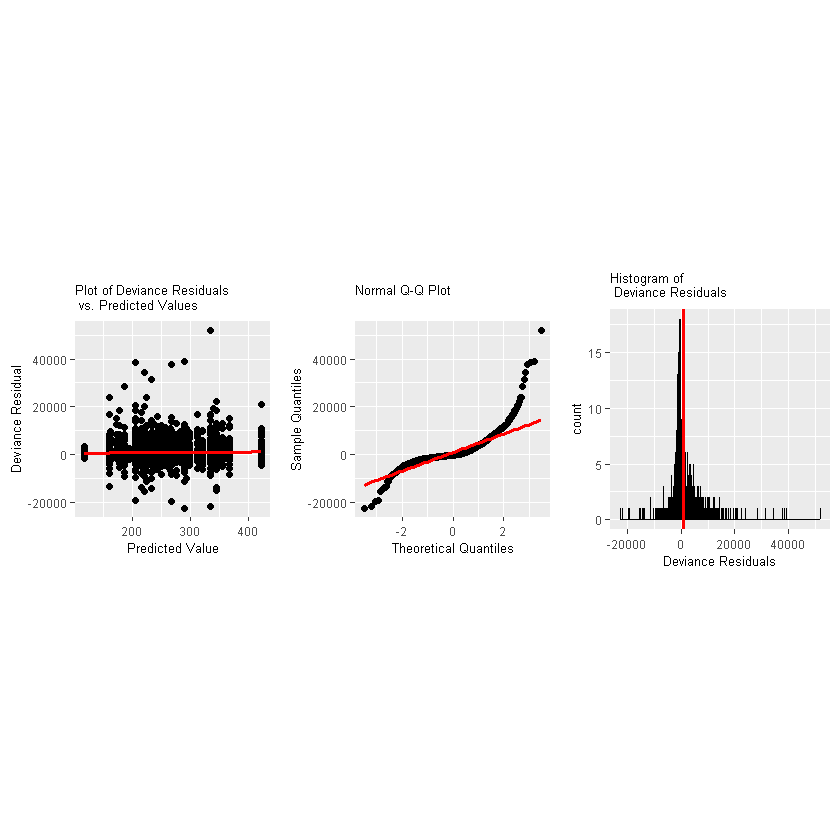

In [34]:
my.glm.function(gauss_add)

When comparing above residual plots, we see that all of these models are distributed evenly around the y-axis. It is very hard to see significant difference among these models. When comparing above Normal Q-Q plots and histogram of deviance residuals, however, Gamma-multiplicative model and Gamma-additive model are more symmetric.

We can also compute the ratio of residual deviance to dispersion parameter and the ratio of residual to null deviance for each model.

In [35]:
Models = c("Poisson-multiplicative", "Poisson-additive", "Gamma-multiplicative", 
           "Gamma-additive", "Gaussian-multiplicative","Gaussian-additive")

Residual_deviance = c(anova(qpoiss_mult)[3,4] / summary(qpoiss_mult)$dispersion, 
                      anova(qpoiss_add)[3,4] / summary(qpoiss_add)$dispersion, 
                      anova(gamma_mult)[3,4] / summary(gamma_mult)$dispersion, 
                      anova(gamma_add)[3,4] / summary(gamma_add)$dispersion,
                      anova(gauss_mult)[3,4] / summary(gauss_mult)$dispersion,
                      anova(gauss_add)[3,4] / summary(gauss_add)$dispersion)

Residual_vs_null_deviance = c(anova(qpoiss_mult)[3,4]/anova(qpoiss_mult)[1,4],
                              anova(qpoiss_add)[3,4]/anova(qpoiss_add)[1,4],
                              anova(gamma_mult)[3,4]/anova(gamma_mult)[1,4],
                              anova(gamma_add)[3,4]/anova(gamma_add)[1,4],
                              anova(gauss_mult)[3,4]/anova(gauss_mult)[1,4],
                              anova(gauss_add)[3,4]/anova(gauss_add)[1,4,])

data.frame(Models, Residual_deviance, Residual_vs_null_deviance)

Models,Residual_deviance,Residual_vs_null_deviance
Poisson-multiplicative,1608.137,0.8219921
Poisson-additive,1609.304,0.8233519
Gamma-multiplicative,1648.115,0.8287071
Gamma-additive,1653.541,0.8291342
Gaussian-multiplicative,2170.997,0.8627219
Gaussian-additive,2171.000,0.8647252


Since Gamma-multiplicative model has smaller computed values than Gamma-additive model, we choose Gamma-multiplicative model as our best model for the next task.

### TASK 3: SELECTING VARIABLES
#### * Gamma-multiplicative Model

In this task, we consider adding two more variables, Bonus and Make, into our Gamma-multiplicative model. Since there are too many classes in each rating variable, we need to reduce the number of classes by conducting linear regression analysis on them.

In [36]:
AHPR3 <- AHPR

In [37]:
AHPR_Kilometres <- lm(PP ~ factor(Kilometres), weights = Insured, data = AHPR3)
summary(AHPR_Kilometres)$coef

,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),196.91813,5.299926,37.154881,1.896000e-234
factor(Kilometres)2,45.68975,7.500827,6.091295,1.320503e-09
factor(Kilometres)3,54.48647,8.693944,6.267175,4.418870e-10
factor(Kilometres)4,74.31841,12.608424,5.894346,4.348598e-09
factor(Kilometres)5,130.53205,14.640581,8.915770,1.001503e-18


In [38]:
AHPR_Zone <- lm(PP ~ factor(Zone), weights = Insured, data = AHPR3)
summary(AHPR_Zone)$coef

,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),326.70158,8.194660,39.867620,2.160302e-261
factor(Zone)2,-66.91576,11.120012,-6.017598,2.071655e-09
factor(Zone)3,-101.05215,10.872177,-9.294565,3.476027e-20
factor(Zone)4,-127.00065,9.644953,-13.167576,3.731606e-38
factor(Zone)5,-85.01398,15.783916,-5.386115,7.976172e-08
factor(Zone)6,-108.02481,12.403160,-8.709458,5.927759e-18
factor(Zone)7,-173.44197,34.866565,-4.974450,7.055928e-07


In [39]:
AHPR_Bonus <- lm(PP ~ factor(Bonus), weights = Insured, data = AHPR3)
summary(AHPR_Bonus)$coef

,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),538.3349,9.107150,59.11123,0.000000e+00
factor(Bonus)2,-176.2743,13.342623,-13.21137,2.179222e-38
factor(Bonus)3,-229.7455,13.839964,-16.60015,2.322966e-58
factor(Bonus)4,-265.0226,14.238011,-18.61374,7.097932e-72
factor(Bonus)5,-289.6104,13.441971,-21.54523,1.761892e-93
factor(Bonus)6,-292.9642,11.647301,-25.15297,9.255200e-123
factor(Bonus)7,-361.0066,9.598684,-37.61002,6.619637e-239


In [40]:
AHPR_Make <- lm(PP ~ factor(Make), weights = Insured, data = AHPR3)
summary(AHPR_Make)$coef

,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),254.61517,9.845385,25.8613729,8.533799e-129
factor(Make)2,16.78908,23.455311,0.7157903,4.741978e-01
factor(Make)3,-37.31384,23.940779,-1.5585891,1.192393e-01
factor(Make)4,-123.07361,21.123717,-5.8263235,6.510270e-09
factor(Make)5,20.23276,23.003404,0.8795550,3.791977e-01
factor(Make)6,-71.77896,16.666862,-4.3066871,1.730897e-05
factor(Make)7,-45.80034,23.892710,-1.9169169,5.537950e-02
factor(Make)8,47.38665,32.401239,1.4624951,1.437502e-01
factor(Make)9,-16.05450,10.508105,-1.5278207,1.267026e-01


From the coefficients of Estimate computed above, we can combine several classes in each rating variable.

In [41]:
AHPR3$Kilometres <- recode(AHPR3$Kilometres,"c('3','4')='2'")
AHPR3$Zone <- recode(AHPR3$Zone,"c('5')='2'; c('4','6')='3'")
AHPR3$Bonus <- recode(AHPR3$Bonus,"c('4','5','6')='3'")
AHPR3$Make <- recode(AHPR3$Make,"c('5','8')='2';c('6','7','9')='3'")

We can also replace 0 by 0.001 in a new column PP_pos as we have done in task 2.

In [42]:
PP_pos <- AHPR3[,8] 
PP_pos[AHPR3[,7]==0] <- 0.001 
AHPR3$PP_pos <- PP_pos  

To select which rating variables will be retained in the final model, we can look at the AIC information. The smaller AIC, the better.

Let us start from the Gamma-multiplicative model with four rating variables.

In [43]:
gamma_full <- glm(PP_pos ~ factor(Kilometres) + factor(Zone) + factor(Bonus) + factor(Make), 
                  data=AHPR3, family=Gamma(link="log"), weights=Insured, start=c(6.57,0,0,0,0,0,0,0,0,0,0,0)) 

drop1(gamma_full,test="LRT")

,Df,Deviance,AIC,scaled dev.,Pr(>Chi)
<none>,NA,249724.7,26764862,NA,NA
factor(Kilometres),2,309007.5,26765500,642.0705,3.768408e-140
factor(Zone),3,297889.9,26765378,521.6605,9.645535e-113
factor(Bonus),3,564617.3,26768267,3410.4899,0.000000e+00
factor(Make),3,281269.7,26765198,341.6529,9.572383e-74


Next we consider all possible interaction terms added into the model.

In [44]:
add1(gamma_full, ~ .^2, test="LRT")

Warning message:
"glm.fit: algorithm did not converge"Warning message:
"glm.fit: algorithm did not converge"

,Df,Deviance,AIC,scaled dev.,Pr(>Chi)
<none>,NA,249724.7,26764862,NA,NA
factor(Kilometres):factor(Zone),6,249341.0,26764870,4.155181,0.655685295
factor(Kilometres):factor(Bonus),6,248096.9,26764857,17.630375,0.007225446
factor(Kilometres):factor(Make),6,310935.2,26765537,0.000000,1.000000000
factor(Zone):factor(Bonus),9,247768.6,26764859,21.186166,0.011848980
factor(Zone):factor(Make),9,575890.9,26768413,0.000000,1.000000000
factor(Bonus):factor(Make),9,247529.0,26764857,23.780697,0.004661826


Only three interaction terms are significant, so we add these three terms into our Gamma-multiplicative model.

In [45]:
gamma_final <- glm(PP_pos ~ factor(Kilometres) + factor(Zone) + factor(Bonus) + factor(Make) + 
                   factor(Kilometres):factor(Bonus) + factor(Zone):factor(Bonus) + factor(Bonus):factor(Make), 
                   data=AHPR3, family=Gamma(link="log"), weights=Insured, 
                   start=c(6.57,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0)) 

drop1(gamma_final,test="LRT")

,Df,Deviance,AIC,scaled dev.,Pr(>Chi)
<none>,NA,244119.1,26709872,NA,NA
factor(Kilometres):factor(Bonus),6,245510.1,26709876,15.67883,0.015585670
factor(Zone):factor(Bonus),9,246165.3,26709877,23.06438,0.006053343
factor(Bonus):factor(Make),9,246104.8,26709876,22.38248,0.007742677


Given the overall interaction terms are significant and has the smallest AIC, this final model will be our best model so far. However, we must check three graphs of our final Gamma-multiplicative model.

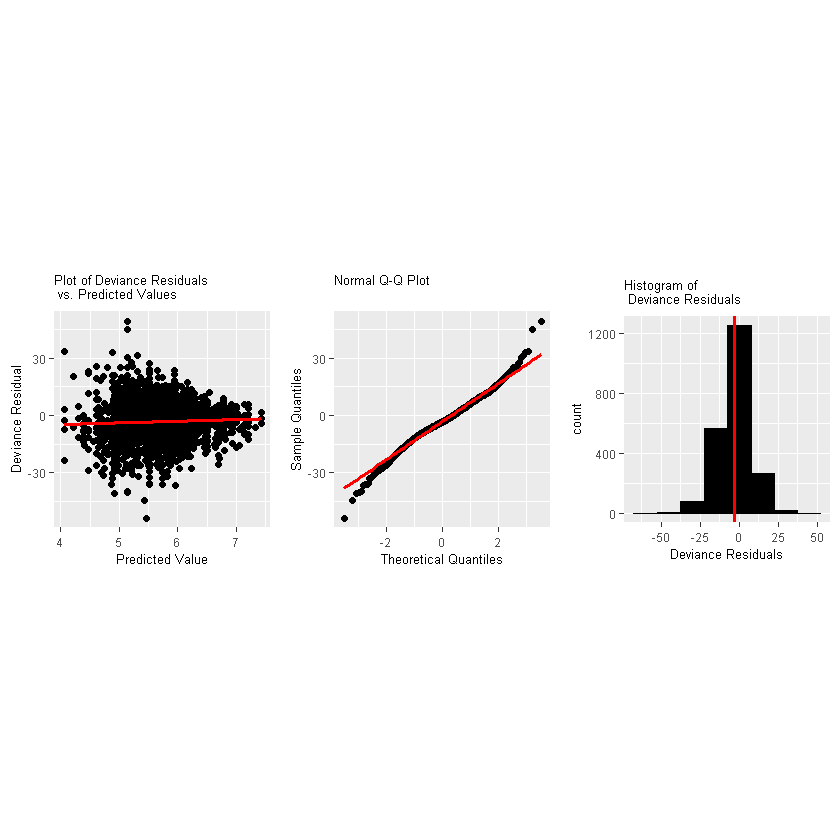

In [46]:
my.glm.function(gamma_final)

The skewness is better than prior Gamma-multiplicative model with two variables, since the Q-Q plot is almost straight line. However, the variance for smaller fitted values is greater than for larger ones. This is called "Hetroskedasticity", non-constant variance. We can try the quasi-Poisson model because it has a smaller variance at smaller fitted values.

### * quasi-Poisson Model

In [47]:
qposs_final <- glm(PP_pos ~ factor(Kilometres) + factor(Zone) + factor(Bonus) + factor(Make) + 
                   factor(Kilometres):factor(Bonus) + factor(Zone):factor(Bonus) + factor(Bonus):factor(Make),
                   data=AHPR3, family=quasipoisson(link="log"), weights=Insured, 
                   start=c(6.57,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0)) 

drop1(qposs_final,test="LRT")

,Df,Deviance,scaled dev.,Pr(>Chi)
<none>,NA,42052375,NA,NA
factor(Kilometres):factor(Bonus),6,42345678,12.86171,0.0452853683
factor(Zone):factor(Bonus),9,42554890,22.03593,0.0087658071
factor(Bonus):factor(Make),9,42778696,31.85013,0.0002113613


Three graphs of our quasi-Poisson model are

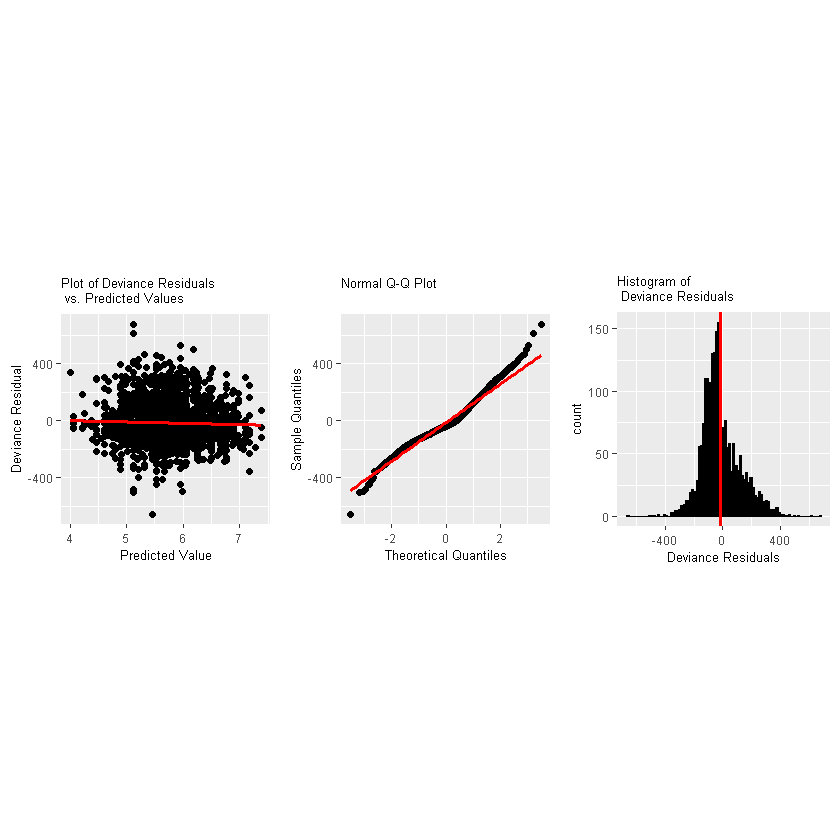

In [48]:
my.glm.function(qposs_final)

This looks better in all three graphs. We will choose this model as our final model.